In [1]:
import requests, zipfile, io, gzip
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

In [ ]:
def debug_geoid_ascii(zip_url, max_lines=600, inspect_range=(520,530)):
    # 1) download & open
    r = requests.get(zip_url, stream=True)
    r.raise_for_status()
    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        asc_name = next(n for n in z.namelist() if n.lower().endswith('.asc'))
        with z.open(asc_name) as f:
            # read all lines into a list of decoded strings
            lines = [L.decode('ascii', errors='replace').rstrip('\r\n') for L in f.readlines()]

    print(f"=== First 10 lines (header + early data) of {asc_name} ===")
    for i, line in enumerate(lines[:10], start=1):
        print(f"{i:3d}: {line!r}")
    print()

    print(f"=== Token counts for lines 1–{max_lines} ===")
    for i, line in enumerate(lines[:max_lines], start=1):
        tokens = line.strip().split()
        print(f"Line {i:4d}: {len(tokens)} tokens")
    print()

    start, end = inspect_range
    print(f"=== Raw lines {start}–{end} ===")
    for i in range(start-1, end):
        if i < len(lines):
            print(f"{i+1:4d}: {lines[i]!r}")
        else:
            print(f"{i+1:4d}: <out of range>")
    print()

url18 = 'https://geodesy.noaa.gov/PC_PROD/GEOID18/Format_ascii/g2018u0.asc.zip'
debug_geoid_ascii(url18)

In [5]:
import requests
import gzip
import io

def debug_geoid_ascii(file_url, max_lines=600, inspect_range=(520,530)):
    # 1) download & open
    r = requests.get(file_url, stream=True)
    r.raise_for_status()
    
    # Check if it's a gzip file based on URL or content
    if file_url.endswith('.gz'):
        # Handle gzip file
        with gzip.open(io.BytesIO(r.content), 'rt', encoding='ascii', errors='replace') as f:
            lines = [line.rstrip('\r\n') for line in f.readlines()]
        file_name = file_url.split('/')[-1]
    else:
        # Handle zip file (original logic)
        import zipfile
        with zipfile.ZipFile(io.BytesIO(r.content)) as z:
            asc_name = next(n for n in z.namelist() if n.lower().endswith('.asc'))
            with z.open(asc_name) as f:
                lines = [L.decode('ascii', errors='replace').rstrip('\r\n') for L in f.readlines()]
        file_name = asc_name

    print(f"=== First 10 lines (header + early data) of {file_name} ===")
    for i, line in enumerate(lines[:10], start=1):
        print(f"{i:3d}: {line!r}")
    print()

    print(f"=== Token counts for lines 1–{max_lines} ===")
    for i, line in enumerate(lines[:max_lines], start=1):
        tokens = line.strip().split()
        print(f"Line {i:4d}: {len(tokens)} tokens")
    print()

    start, end = inspect_range
    print(f"=== Raw lines {start}–{end} ===")
    for i in range(start-1, end):
        if i < len(lines):
            print(f"{i+1:4d}: {lines[i]!r}")
        else:
            print(f"{i+1:4d}: <out of range>")
    print()

url18 = 'https://geodesy.noaa.gov/PC_PROD/GEOID03/g2003u01.asc.gz'
debug_geoid_ascii(url18)

=== First 10 lines (header + early data) of g2003u01.asc.gz ===
  1: '     40.000000000000    230.00000000000    1.6666666666667D-02    1.6666666666667D-02'
  2: '   1081  1141  1'
  3: '  -37.2320  -37.2242  -37.2164  -37.2090  -37.2021  -37.1961  -37.1904  -37.1845'
  4: '  -37.1785  -37.1717  -37.1649  -37.1576  -37.1505  -37.1432  -37.1362  -37.1294'
  5: '  -37.1228  -37.1163  -37.1096  -37.1028  -37.0956  -37.0879  -37.0797  -37.0714'
  6: '  -37.0633  -37.0560  -37.0498  -37.0455  -37.0430  -37.0425  -37.0435  -37.0452'
  7: '  -37.0474  -37.0489  -37.0502  -37.0503  -37.0500  -37.0491  -37.0483  -37.0475'
  8: '  -37.0471  -37.0468  -37.0469  -37.0476  -37.0488  -37.0508  -37.0537  -37.0578'
  9: '  -37.0631  -37.0702  -37.0786  -37.0883  -37.0989  -37.1097  -37.1203  -37.1301'
 10: '  -37.1390  -37.1469  -37.1540  -37.1604  -37.1663  -37.1721  -37.1810  -37.1903'

=== Token counts for lines 1–600 ===
Line    1: 4 tokens
Line    2: 3 tokens
Line    3: 8 tokens
Line    4: 8 toke

In [ ]:
def load_geoid_ascii(url):
    """
    Download a zipped (.zip) or gzipped (.gz) ASCII geoid grid, unpack in-memory,
    read header & data, and return (data, hdr).
    """
    # 1) Stream the file
    r = requests.get(url, stream=True)
    r.raise_for_status()
    content = r.content  # small enough (~28 MB for these files)

    # 2) Decompress to a bytes-buffer that behaves like a file
    if url.lower().endswith('.zip'):
        buf = io.BytesIO(content)
        z   = zipfile.ZipFile(buf)
        # pick the .asc inside
        asc_name = next(n for n in z.namelist() if n.lower().endswith('.asc'))
        fobj = z.open(asc_name)
    elif url.lower().endswith('.gz'):
        buf = io.BytesIO(content)
        fobj = gzip.GzipFile(fileobj=buf)
    else:
        raise ValueError("URL must end in .zip or .gz")

    # Read header
    # Wrap in TextIO so we can readline()
    txt = io.TextIOWrapper(fobj, encoding='ascii', errors='replace')

    # Read the first line to determine format
    first_line = txt.readline().strip()
    first_toks = first_line.split()

    # Initialize header variables
    ncols, nrows, xll, yll, cell = None, None, None, None, None

    if len(first_toks) == 2:
        # ESRI style (6 key/value lines, first line has 2 tokens: KEY VALUE)
        txt.seek(0) # Rewind to start for full header read
        hdr = {}
        for _ in range(6):
            line = txt.readline().strip()
            k, v = line.split()
            hdr[k.lower()] = float(v)
        ncols = int(hdr['ncols'])
        nrows = int(hdr['nrows'])
        xll   = hdr.get('xllcorner', hdr.get('xllcenter'))
        yll   = hdr.get('yllcorner', hdr.get('yllcenter'))
        cell  = hdr['cellsize']
        print(f"DEBUG: Detected ESRI-style header for {url}")

    elif len(first_toks) == 6:
        # NOAA/GTX style: all 6 float values on the first line
        # This is the format that worked for url12b in your older code.
        # Values like '24.000000000000 230.00000000000 0.1666666666667 0.1666666666667 2041 4201'
        vals = list(map(float, first_toks))
        yll, xll, dlat, dlon, nrf, ncf = vals[:6]
        nrows = int(nrf)
        ncols = int(ncf)
        cell  = (dlat + dlon) / 2.0
        print(f"DEBUG: Detected NOAA/GTX (6-token) header for {url}")

    elif len(first_toks) == 4:
        # NOAA/GTX style: Header values split across first two lines (for g2003u01.asc.gz)
        # First line: YLL, XLL, DLAT, DLON (e.g., 'D-02' notation)
        # Second line: NRF, NCF, (extra value)
        converted_first_toks = [t.replace('D', 'e').replace('d', 'e') for t in first_toks]
        yll, xll, dlat, dlon = map(float, converted_first_toks)

        second_line = txt.readline().strip()
        second_toks = second_line.split()
        converted_second_toks = [t.replace('D', 'e').replace('d', 'e') for t in second_toks]
        
        if len(converted_second_toks) < 2:
            raise ValueError(f"Expected at least 2 values on second header line, got {len(converted_second_toks)}: '{second_line}' for URL: {url}")
        
        nrf, ncf = map(float, converted_second_toks[:2]) # Take only the first two needed values
        nrows = int(nrf)
        ncols = int(ncf)
        cell  = (dlat + dlon) / 2.0
        print(f"DEBUG: Detected NOAA/GTX (4-token first line) header for {url}")

    elif len(first_toks) == 7: # <--- NEW CONDITION TO HANDLE URL12B's SPECIFIC HEADER
        # NOAA/GTX style: 7 float values on the first line (e.g., g2012bu0.asc.gz)
        # Example: '24.000000000000 230.00000000000 0.1666666666667E-01 0.1666666666667E-01 2041 4201 1'
        # We need the first 6 values; the 7th is ignored.
        # 'E' notation is handled by float() directly, so no replace needed here.
        vals = list(map(float, first_toks[:6])) # Take only the first 6 values
        yll, xll, dlat, dlon, nrf, ncf = vals
        nrows = int(nrf)
        ncols = int(ncf)
        cell  = (dlat + dlon) / 2.0
        print(f"DEBUG: Detected NOAA/GTX (7-token) header for {url}")

    else:
        # If none of the known header formats match
        raise ValueError(f"Unsupported header format for URL: {url}. First line has {len(first_toks)} tokens: '{first_line}'")

    # Construct the header dictionary (common for all successful paths)
    hdr = {
        'ncols': ncols,
        'nrows': nrows,
        'xllcorner': xll if abs(xll) <= 180 else xll - 360, # Adjust longitude if >180
        'yllcorner': yll,
        'cellsize': cell
    }

    rest = txt.read()
    # Always replace 'D' with 'e' for the data section, as this seems generally needed
    rest_converted = rest.replace('D', 'e').replace('d', 'e')
    allval = np.fromstring(rest_converted, sep=' ')

    expected = nrows * ncols
    if allval.size != expected:
        raise ValueError(f"Expected {expected} values, got {allval.size} for grid size {nrows}x{ncols} for URL: {url}")
    data = allval.reshape(nrows, ncols)

    return data, hdr

# URLs
url18  = 'https://geodesy.noaa.gov/PC_PROD/GEOID18/Format_ascii/g2018u0.asc.zip' # This one is ZIP (ESRI style)
url03 = 'https://geodesy.noaa.gov/PC_PROD/GEOID03/g2003u01.asc.gz' # This is the GZ one with 4-token first line
#url12b = 'https://www.ngs.noaa.gov/PC_PROD/GEOID12B/Format_ascii/g2012bu0.asc.gz' # This is the GZ one with 7-token first line
url12b = 'https://www.ngs.noaa.gov/PC_PROD/GEOID12B/Format_ascii/g2012bu1.asc.gz'

print(f"Loading GEOID03 from: {url03}")
g03, h03 = load_geoid_ascii(url03)
print(f"Loaded GEOID03. Data shape: {g03.shape}, Header: {h03}")

print(f"\nLoading GEOID12B from: {url12b}")
g12, h12 = load_geoid_ascii(url12b)
print(f"Loaded GEOID12B. Data shape: {g12.shape}, Header: {h12}")

print(f"\nLoading GEOID18 from: {url18}")
g18, h18 = load_geoid_ascii(url18)
print(f"Loaded GEOID18. Data shape: {g18.shape}, Header: {h18}")

Loading GEOID03 from: https://geodesy.noaa.gov/PC_PROD/GEOID03/g2003u01.asc.gz
DEBUG: Detected NOAA/GTX (4-token first line) header for https://geodesy.noaa.gov/PC_PROD/GEOID03/g2003u01.asc.gz
Loaded GEOID03. Data shape: (1081, 1141), Header: {'ncols': 1141, 'nrows': 1081, 'xllcorner': -130.0, 'yllcorner': 40.0, 'cellsize': 0.016666666666667}

Loading GEOID12B from: https://www.ngs.noaa.gov/PC_PROD/GEOID12B/Format_ascii/g2012bu1.asc.gz
DEBUG: Detected NOAA/GTX (7-token) header for https://www.ngs.noaa.gov/PC_PROD/GEOID12B/Format_ascii/g2012bu1.asc.gz
Loaded GEOID12B. Data shape: (1081, 1141), Header: {'ncols': 1141, 'nrows': 1081, 'xllcorner': -130.0, 'yllcorner': 40.0, 'cellsize': 0.01666666666667}

Loading GEOID18 from: https://geodesy.noaa.gov/PC_PROD/GEOID18/Format_ascii/g2018u0.asc.zip
DEBUG: Detected NOAA/GTX (7-token) header for https://geodesy.noaa.gov/PC_PROD/GEOID18/Format_ascii/g2018u0.asc.zip
Loaded GEOID18. Data shape: (2041, 4201), Header: {'ncols': 4201, 'nrows': 2041, '

In [47]:
g03, g18, h18

(array([[-37.232 , -37.2242, -37.2164, ..., -15.8379, -15.837 , -15.8564],
        [-37.2227, -37.215 , -37.2072, ..., -15.8144, -15.8099, -15.829 ],
        [-37.2088, -37.2011, -37.1931, ..., -15.8156, -15.8217, -15.8467],
        ...,
        [ -1.1713,  -1.187 ,  -1.2043, ..., -28.7928, -28.8112, -28.8294],
        [ -1.1529,  -1.1744,  -1.1951, ..., -28.8346, -28.8532, -28.8716],
        [ -1.1219,  -1.1478,  -1.1698, ..., -28.8768, -28.8955, -28.9139]]),
 array([[-39.7147, -39.7367, -39.7586, ..., -48.0396, -48.016 , -47.9924],
        [-39.7183, -39.7403, -39.7621, ..., -48.036 , -48.0123, -47.9884],
        [-39.7215, -39.7433, -39.7649, ..., -48.032 , -48.0081, -47.9839],
        ...,
        [ -1.054 ,  -1.0464,  -1.0459, ...,   2.9824,   3.057 ,   3.1288],
        [ -1.082 ,  -1.0681,  -1.0588, ...,   3.0583,   3.1316,   3.2019],
        [ -1.1138,  -1.1129,  -1.1112, ...,   3.1352,   3.2069,   3.2754]]),
 {'ncols': 4201,
  'nrows': 2041,
  'xllcorner': -130.0,
  'yllcorner'

In [18]:
g12, h12

(array([[479.299 , 477.889 , 476.48  , ...,  17.3792,  18.7467,  20.1221],
        [479.056 , 477.646 , 476.236 , ...,  17.999 ,  19.3224,  20.6592],
        [478.819 , 477.409 , 475.999 , ...,  18.7814,  20.053 ,  21.3437],
        ...,
        [ 15.8975,  15.8141,  15.7923, ..., 265.315 , 266.301 , 267.288 ],
        [ 17.7427,  17.668 ,  17.6485, ..., 265.311 , 266.296 , 267.282 ],
        [ 19.5899,  19.5224,  19.5047, ..., 265.319 , 266.304 , 267.29  ]]),
 {'ncols': 1141,
  'nrows': 1081,
  'xllcorner': -130.0,
  'yllcorner': 40.0,
  'cellsize': 0.01666666666667})

In [49]:
diff = g12 - g03
diff

array([[-0.2425, -0.2423, -0.2421, ...,  0.0766,  0.0689,  0.0984],
       [-0.244 , -0.2437, -0.2444, ...,  0.0563,  0.0423,  0.0643],
       [-0.2449, -0.2456, -0.2465, ...,  0.0851,  0.0852,  0.1143],
       ...,
       [ 0.1286,  0.1589,  0.1842, ..., -0.0139, -0.0125, -0.0105],
       [ 0.0875,  0.1269,  0.1596, ...,  0.0018,  0.0032,  0.0048],
       [ 0.0265,  0.0549,  0.0791, ...,  0.0189,  0.0193,  0.0203]])

In [20]:
import geopandas as gpd
states = gpd.read_file(
    "https://raw.githubusercontent.com/ResidentMario/geoplot-data/master/contiguous-usa.geojson"
)

In [42]:
g03.mean()

-18.34922806414031

In [51]:
diff.mean()

-0.034477264372829726

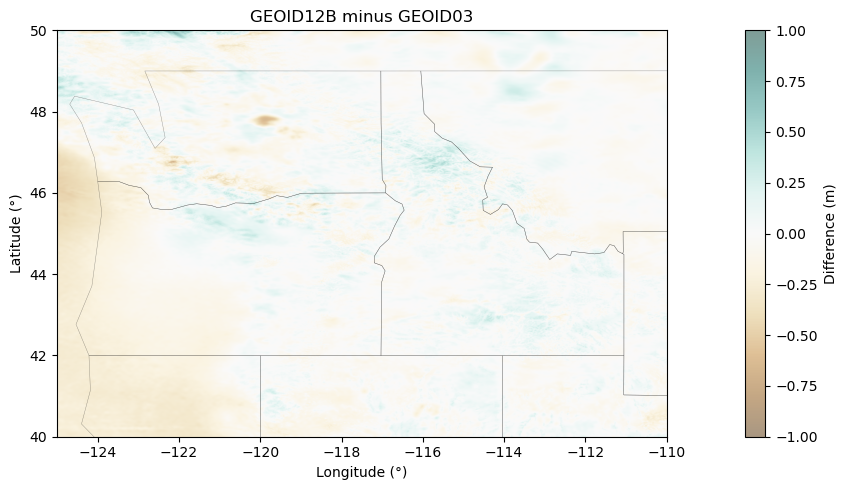

In [54]:
#norm = TwoSlopeNorm(vmin=0, vcenter=np.quantile(diff, 0.5), vmax=250)
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
#xmin = h18['xllcorner']
xmin = -125
#xmax = xmin + h18['ncols'] * h18['cellsize']
xmax=-110
#ymin = h18['yllcorner']
ymin=40
#ymax = ymin + h18['nrows'] * h18['cellsize']
ymax = 50

fig, ax = plt.subplots(figsize=(16,5))
states.boundary.plot(ax=ax, edgecolor='black', alpha=0.4, linewidth=0.3)

ax.imshow(
    diff,
    origin='lower',
    extent=(xmin, xmax, ymin, ymax),
    cmap='BrBG',
    norm=norm,
    alpha=0.5
)

ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.set_title('GEOID12B minus GEOID03')
plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap='BrBG'),
    ax=ax,
    label='Difference (m)',
    alpha=0.5
)
ax.set_aspect('equal')
plt.tight_layout();

In [50]:
import rasterio
from rasterio.merge import merge
# from rasterio.vrt import WarpedVRT
from rasterio.plot import plotting_extent
import mercantile
# Stream & merge SRTM tiles over CONUS 
# Zoom 6 tiles covering roughly from lon -125 to -65, lat 24 to 50:
#    x tiles 20 through 30, y tiles 22 through 27  (WebMercator tile scheme)

# --- 1) Define lon/lat bbox for CONUS ---
lon_min, lon_max = -125.0, -65.0
lat_min, lat_max =  24.0,  50.0

# --- 2) Choose zoom level & compute needed tiles ---
zoom = 6  # ~10 km tiles; use 7 or 8 for finer resolution
tiles = list(mercantile.tiles(lon_min, lat_min, lon_max, lat_max, zoom))

# --- 3) Stream each tile via AWS & Rasterio ---
srcs = []
for tile in tiles:
    url = f"https://s3.amazonaws.com/elevation-tiles-prod/geotiff/{zoom}/{tile.x}/{tile.y}.tif"
    srcs.append(rasterio.open(f"/vsicurl/{url}"))

# --- 4) Merge in memory ---
mosaic, out_trans = merge(srcs)

In [51]:
mosaic

array([[[  -35,   -33,   -33, ...,   482,   535,   555],
        [  -36,   -34,   -37, ...,   453,   499,   532],
        [  -35,   -32,   -35, ...,   429,   461,   505],
        ...,
        [-4777, -4790, -4800, ..., -5652, -5677, -5688],
        [-4762, -4773, -4782, ..., -5651, -5681, -5698],
        [-4746, -4756, -4765, ..., -5653, -5686, -5708]]], dtype=int16)

Well that isn't working

<a list of 103 text.Text objects>

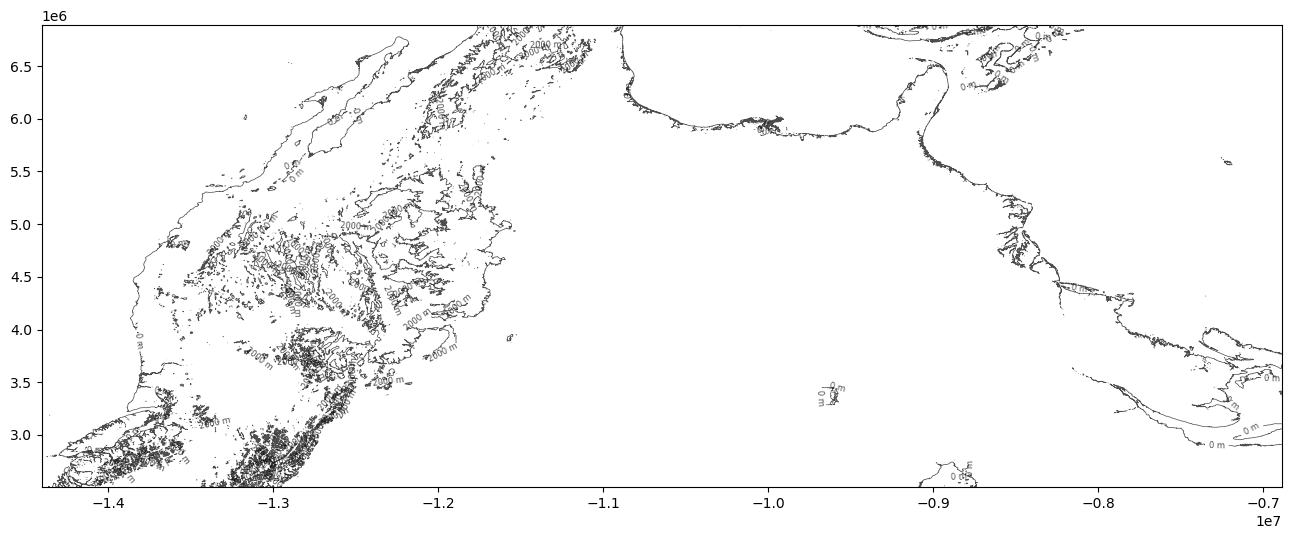

In [53]:
fig, ax = plt.subplots(figsize=(16, 6))

dem = mosaic[0]
extent = plotting_extent(dem, out_trans)  # (xmin, xmax, ymin, ymax)
levels = np.arange(0, 4500, 2000)

cs = ax.contour(
    dem,
    levels=levels,
    extent=extent,
    colors='k',
    linewidths=0.5,
    alpha=0.7,
    zorder=3
)
ax.clabel(cs, fmt='%d m', fontsize=6)

In [55]:
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import array_bounds
# 4) Reproject mosaic -> EPSG:4326
dem3857 = mosaic[0]
src_crs = srcs[0].crs  # EPSG:3857
nrows, ncols = dem3857.shape
# get bounding box in src_crs
left, bottom, right, top = array_bounds(nrows, ncols, out_trans)

dst_crs = 'EPSG:4326'
transform4326, width4326, height4326 = calculate_default_transform(
    src_crs, dst_crs,
    ncols, nrows,
    left, bottom, right, top
)

dem4326 = np.empty((height4326, width4326), dtype=dem3857.dtype)
reproject(
    source=dem3857,
    destination=dem4326,
    src_transform=out_trans,
    src_crs=src_crs,
    dst_transform=transform4326,
    dst_crs=dst_crs,
    resampling=Resampling.bilinear
)

(array([[  -35,   -34,   -34, ...,   502,   536,   547],
        [  -35,   -33,   -35, ...,   456,   493,   511],
        [  -34,   -29,   -28, ...,   460,   482,   497],
        ...,
        [-4780, -4792, -4801, ..., -5668, -5683, -5688],
        [-4763, -4774, -4783, ..., -5669, -5690, -5697],
        [-4749, -4758, -4767, ..., -5672, -5697, -5706]], dtype=int16),
 Affine(0.010415857951464942, 0.0, -129.37499999999997,
        0.0, -0.010415857951464942, 52.48278022207822))

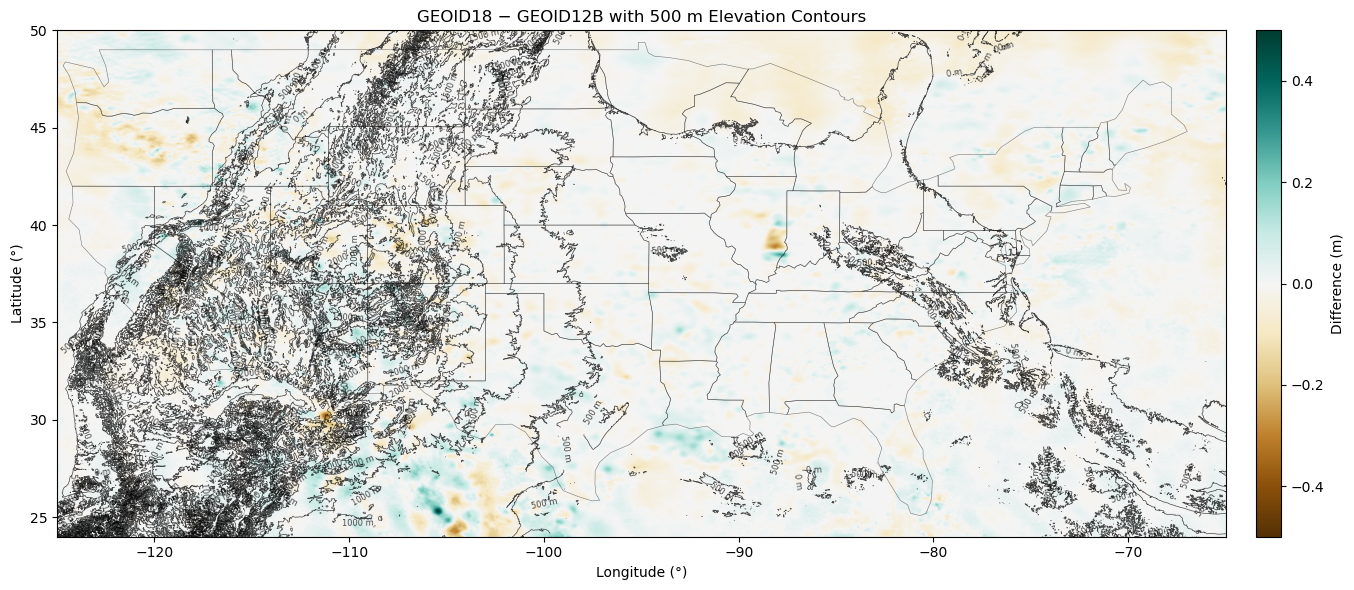

In [56]:
fig, ax = plt.subplots(figsize=(16, 6))

# a) geoid-diff
norm = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
ax.imshow(
    diff,
    origin='lower',
    extent=(lon_min, lon_max, lat_min, lat_max),
    cmap='BrBG',
    norm=norm,
    zorder=1
)

# b) state bndry
states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.4, alpha=0.5, zorder=2)

# c) contours in lat/lon
extent4326 = plotting_extent(dem4326, transform4326)
levels = np.arange(0, 4500, 500)
cs = ax.contour(
    dem4326,
    levels=levels,
    extent=extent4326,
    colors='k',
    linewidths=0.5,
    alpha=0.7,
    zorder=3
)
ax.clabel(cs, fmt='%d m', fontsize=6)

# final styling
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.set_aspect('equal')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.set_title('GEOID18 − GEOID12B with 500 m Elevation Contours')

fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap='BrBG'),
    ax=ax,
    label='Difference (m)',
    fraction=0.025, pad=0.02
)
plt.tight_layout()
plt.show()

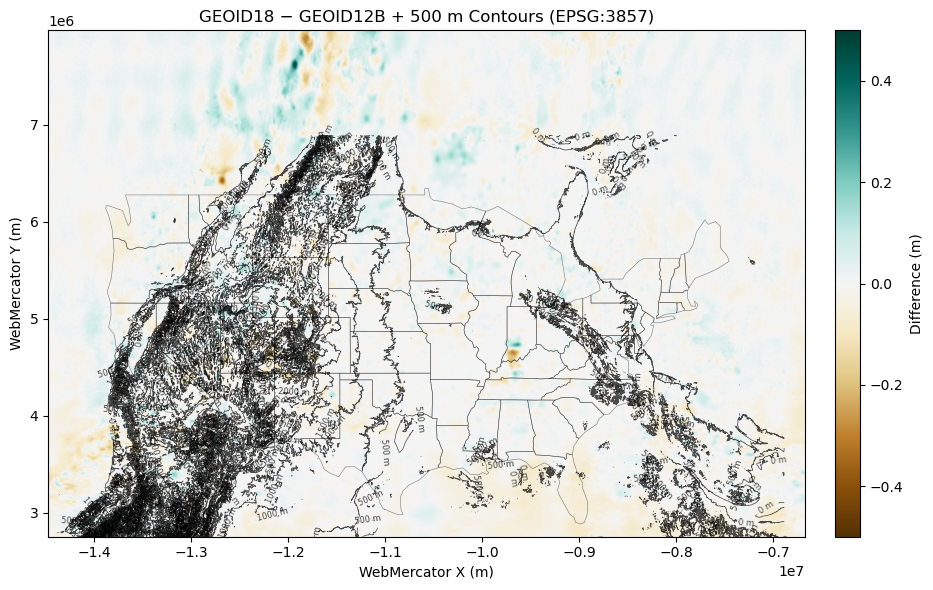

In [57]:
# wack... let's convert everything else to 3857?
from affine import Affine
cell = (h18['cellsize'], h18['cellsize'])
geo_transform = Affine(cell[0], 0, h18['xllcorner'],
                       0, -cell[1], h18['yllcorner'] + cell[1]*h18['nrows'])
# diff is shape (nrows,ncols), src_crs=4326
dst_crs = 'EPSG:3857'
transform3857, width3857, height3857 = calculate_default_transform(
    'EPSG:4326', dst_crs,
    h18['ncols'], h18['nrows'],
    h18['xllcorner'], h18['yllcorner'],
    h18['xllcorner'] + cell[0]*h18['ncols'],
    h18['yllcorner'] + cell[1]*h18['nrows']
)
diff3857 = np.empty((height3857, width3857), dtype=diff.dtype)
reproject(
    source=diff,
    destination=diff3857,
    src_transform=geo_transform,
    src_crs='EPSG:4326',
    dst_transform=transform3857,
    dst_crs=dst_crs,
    resampling=Resampling.bilinear
)

# --- Reproject states to 3857 ---
states_3857 = states.to_crs(epsg=3857)

# --- Plot all in 3857 ---
fig, ax = plt.subplots(figsize=(16, 6))

# a) geoid‐diff raster
norm = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
extent_diff = plotting_extent(diff3857, transform3857)
img = ax.imshow(
    diff3857,
    origin='upper',   # for north‐up WebMercator
    extent=extent_diff,
    cmap='BrBG',
    norm=norm,
    zorder=1
)

# state outlines
states_3857.boundary.plot(ax=ax, edgecolor='black', linewidth=0.4, alpha=0.5, zorder=2)

# SRTM contours
trans3857 = out_trans
extent_dem = plotting_extent(dem3857, trans3857)
levels = np.arange(0, 4500, 500)
cs = ax.contour(
    dem3857,
    levels=levels,
    extent=extent_dem,
    colors='k',
    linewidths=0.5,
    alpha=0.7,
    zorder=3
)
ax.clabel(cs, fmt='%d m', fontsize=6)

ax.set_xlim(extent_diff[0], extent_diff[1])
ax.set_ylim(extent_diff[2], extent_diff[3])
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('WebMercator X (m)')
ax.set_ylabel('WebMercator Y (m)')
ax.set_title('GEOID18 − GEOID12B + 500 m Contours (EPSG:3857)')

fig.colorbar(img, ax=ax, label='Difference (m)', fraction=0.025, pad=0.02)
plt.tight_layout();

womp womp, we'll fix this later

---

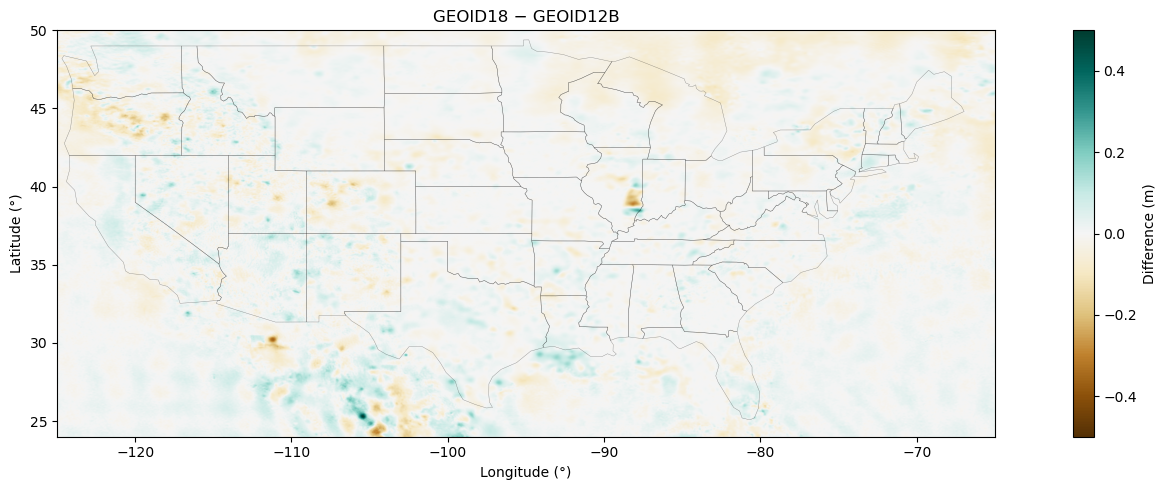

In [42]:
#norm = TwoSlopeNorm(vmin=diff.min(), vcenter=0, vmax=diff.max())
norm = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
#xmin = h18['xllcorner']
xmin = -125
#xmax = xmin + h18['ncols'] * h18['cellsize']
xmax=-65
ymin = h18['yllcorner']
#ymax = ymin + h18['nrows'] * h18['cellsize']
ymax = 50

fig, ax = plt.subplots(figsize=(16,5))
states.boundary.plot(ax=ax, edgecolor='black', alpha=0.4, linewidth=0.3)

ax.imshow(
    diff,
    origin='lower',
    extent=(xmin, xmax, ymin, ymax),
    cmap='BrBG',
    norm=norm
)

ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.set_title('GEOID18 − GEOID12B')
plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap='BrBG'),
    ax=ax,
    label='Difference (m)'
)
ax.set_aspect('equal')
plt.tight_layout();